In [18]:
import numpy as np
import os
import matplotlib.pyplot as plt
import freqopttest.util as util
import freqopttest.data as data

import freqopttest.kernel as kernel
import freqopttest.tst as tst
import collections
from collections import defaultdict
import freqopttest.glo as glo
import sys
import time
import os
import pandas as pd
import pickle
from itertools import combinations
import itertools
from multiprocessing import Pool, cpu_count


In [2]:

def generate_column_pairs(num_columns):
    for window in range(1, num_columns):
        for shift in range(1, num_columns - window + 1):
            for start_point, end_point in itertools.combinations(range(num_columns), 2):
                if end_point - start_point == window:
                    yield start_point, end_point, shift

In [3]:
class MMDTester:
    def __init__(self, df):
        self.df = df

    def get_data(self, start_point, end_point, shift, window):
        min_length = min(self.df.iloc[:, start_point:end_point].shape[0],
                         self.df.iloc[:, end_point + shift:end_point + 2 * shift].shape[0],
                         self.df.iloc[:, start_point + window:end_point + window].shape[0])

        X = np.array(self.df.iloc[:min_length, start_point:end_point])
        Y = np.array(self.df.iloc[:min_length, end_point + shift:end_point + 2 * shift])
        Z = np.array(self.df.iloc[:min_length, start_point + window:end_point + window])

        return X, Y, Z

    def perform_tests(self, X, Y, Z):
        data_sample = data.TSTData(X, Y)
        test_data_one = data.TSTData(X, Z)
        test_data_two = data.TSTData(Y, Z)

        tr, te = data_sample.split_tr_te(tr_proportion=0.9, seed=100)

        med = util.meddistance(tr.stack_xy())
        widths = [(med * f) for f in 2.0 ** np.linspace(-1, 4, 25)]
        list_kernels = [kernel.KGauss(w ** 2) for w in widths]

        besti, powers = tst.LinearMMDTest.grid_search_kernel(tr, list_kernels, alpha=0.01)

        plt.plot(widths, powers, 'o-')
        plt.xlabel('Gaussian width')
        plt.ylabel('test power')
        plt.title('median distance = %.3g. Best width: %.3g' % (med, widths[besti]))
        plt.show()

        best_ker = list_kernels[besti]
        lin_mmd_test = tst.LinearMMDTest(best_ker, alpha=0.01)

        test_results_one = {
            'widths': widths,
            'med': med,
            'besti': besti,
            'powers': powers,
            'med_on_test_data': util.meddistance(test_data_one.stack_xy()),
            'test_result': lin_mmd_test.perform_test(test_data_one),
            'test_variance': lin_mmd_test.variance(X, Z, best_ker),
            'two_moments': lin_mmd_test.two_moments(X, Z, best_ker),
            'compute_unbiased_linear_estimator': lin_mmd_test.compute_stat(test_data_one)
        }

        test_results_two = {
            'test_result': lin_mmd_test.perform_test(test_data_two),
            'test_variance': lin_mmd_test.variance(Y, Z, best_ker),
            'med_on_test_data': util.meddistance(test_data_two.stack_xy()),
            'two_moments': lin_mmd_test.two_moments(Y, Z, best_ker),
            'compute_unbiased_linear_estimator': lin_mmd_test.compute_stat(test_data_two)
        }

        return test_results_one, test_results_two

    def analyze(self, start_point, end_point, shift, window):
        X, Y, Z = self.get_data(start_point, end_point, shift, window)
        return self.perform_tests(X, Y, Z)

# Usage example:
# unpickled_df = ... # Load your DataFrame
# mmd_tester = MMDTester(unpickled_df)
# test_results_one, test_results_two = mmd_tester.analyze(start_point, end_point, shift, window)


In [4]:
file = ('/media/ak/T7/August11th2022Experiments/LinearMMDInputFiles/G_1_calendar_mfdfa_dicts_all_dates.pkl')
outputDir = '/media/ak/T7/August11th2022Experiments/LinearMMDOutputFiles'
variables = ['n_F', 'list_H', 'list_H_intercept', 'tau', 'alpha', 'mfSpect']

In [5]:
data_dict = pd.read_pickle(file)

# Create a list of DataFrames with names from the dictionary keys
dataframes = [pd.DataFrame(data_dict[key]).assign(name=key) for key in data_dict]

n_f = data_dict['n_F']
list_H = data_dict['list_H']
tau = data_dict['tau']
alpha = data_dict['alpha']

In [6]:
tau_df = pd.DataFrame.from_dict(tau)
alpha_df = pd.DataFrame.from_dict(alpha)

In [7]:

length = tau_df .shape[1]
print(length)
test_results_one_dict = defaultdict(dict)
test_results_two_dict = defaultdict(dict)

91


In [8]:
# Generate all possible combinations of column pairs
column_pairs = list(combinations(tau_df.columns, 2))

In [9]:


# 

# # Set your desired values for window and shift
# window = 1
# shift = 1

# num_columns = unpickled_df.shape[1]
# mmd_tester = MMDTester(unpickled_df)

# column_combinations = list(generate_column_pairs(num_columns, window, shift))

# # Initialize an empty dictionary to store the results
# results = {}

# # Iterate through all column combinations
# for start_point, end_point, shift in column_combinations:
#     test_results_one, test_results_two = mmd_tester.analyze(start_point, end_point, shift, window)
    
#     col1, col2 = unpickled_df.columns[start_point], unpickled_df.columns[end_point + shift]
#     results[f"{col1}_vs_{col2}"] = (test_results_one, test_results_two)

# print(results)

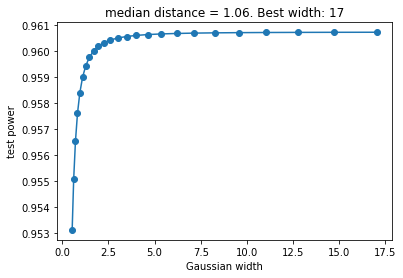

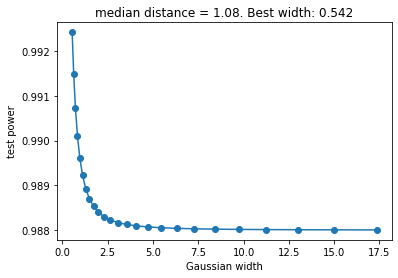

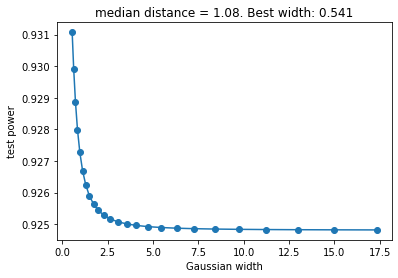

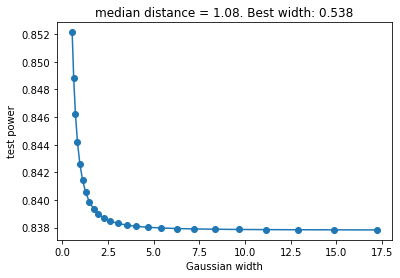

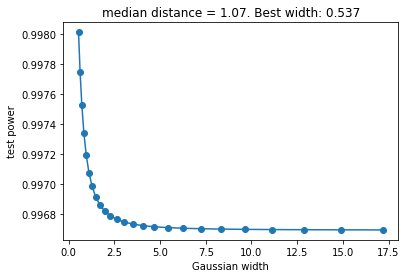

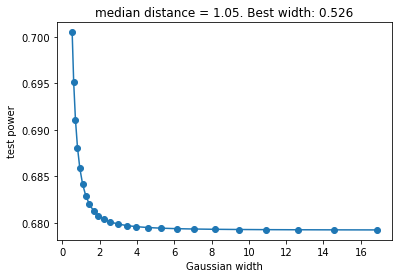

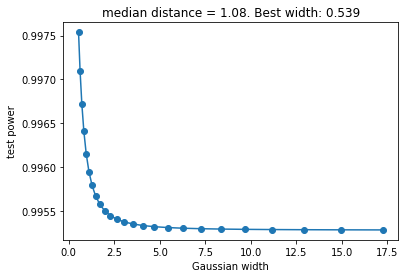

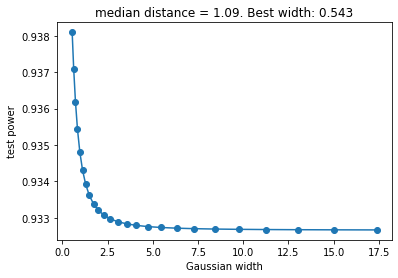

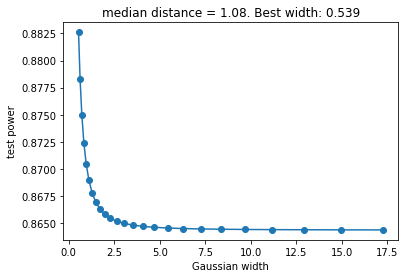

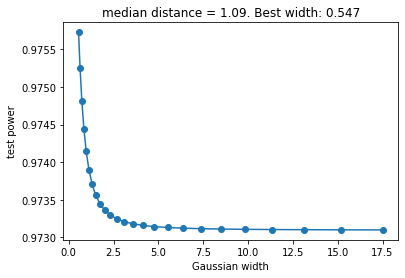

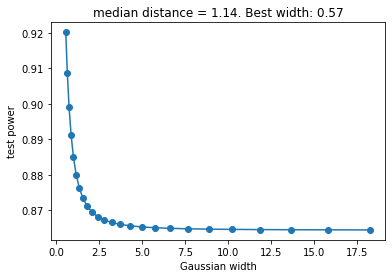

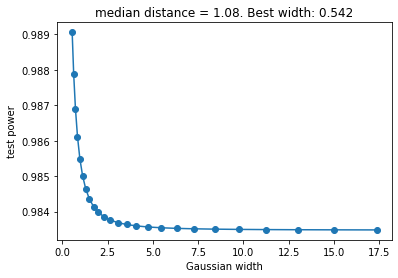

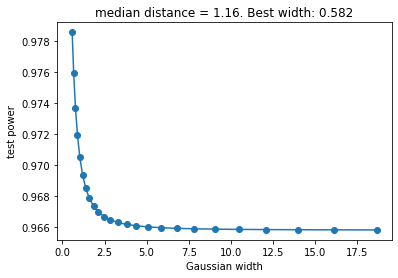

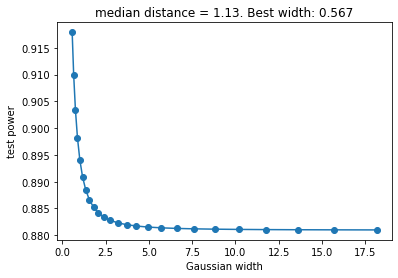

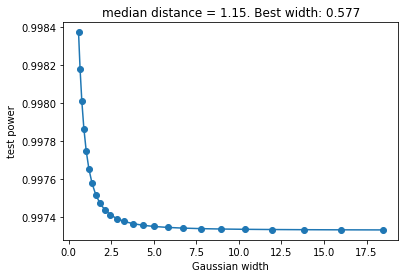

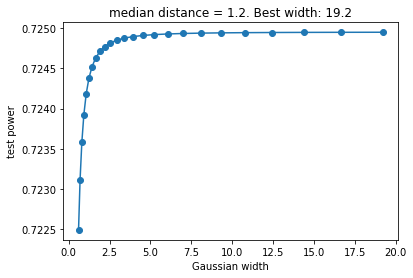

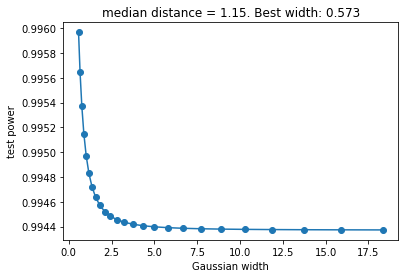

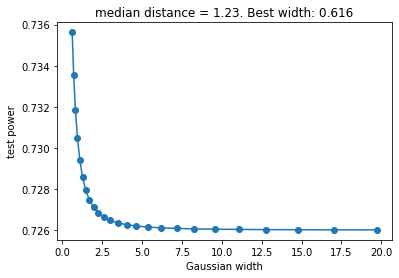

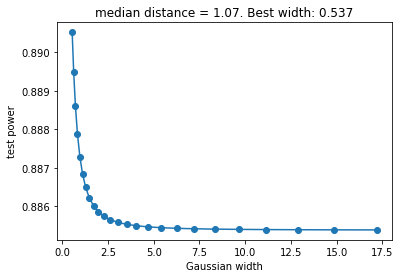

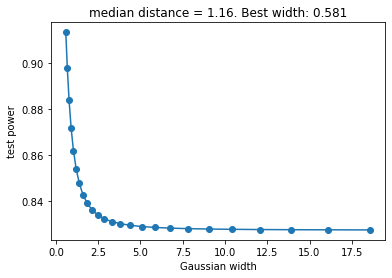

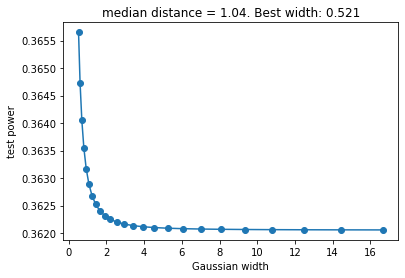

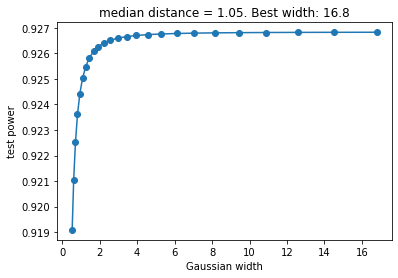

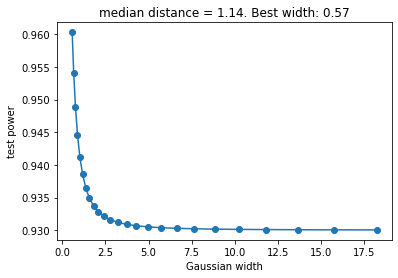

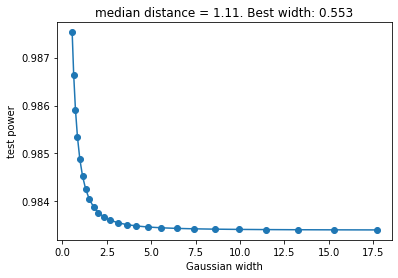

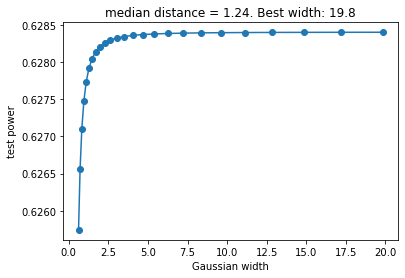

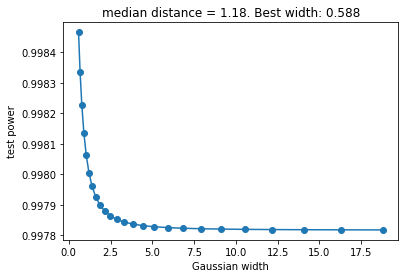

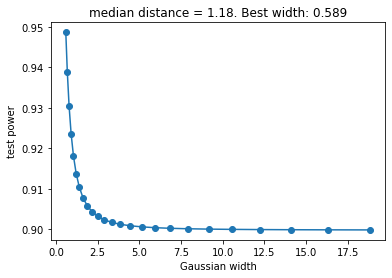

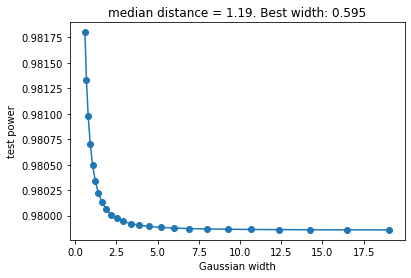

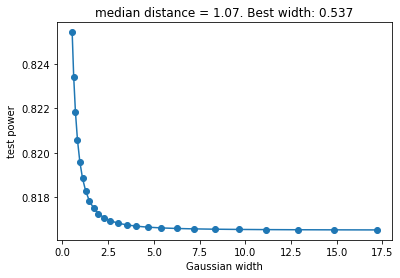

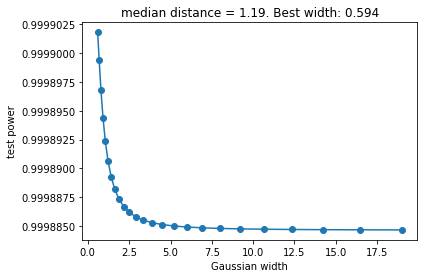

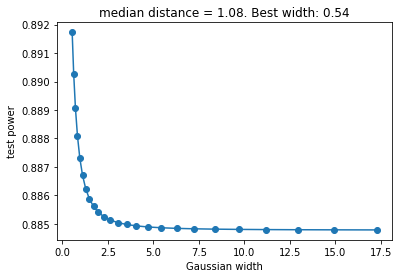

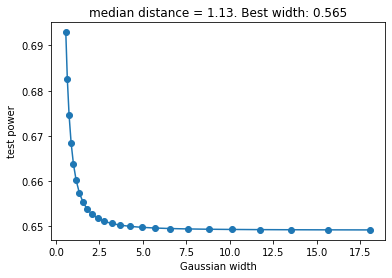

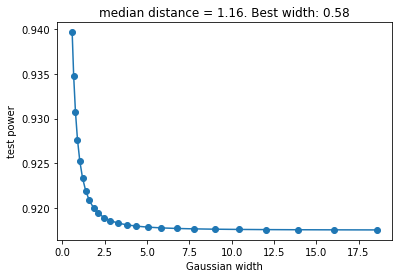

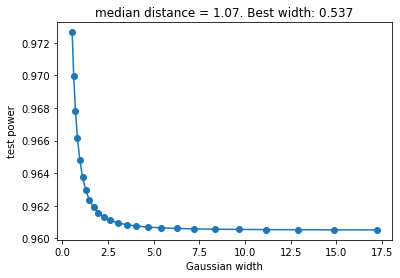

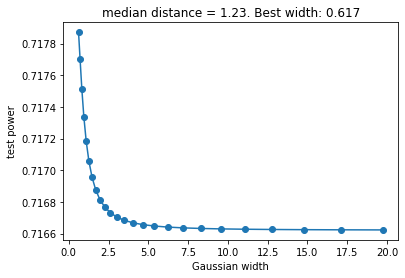

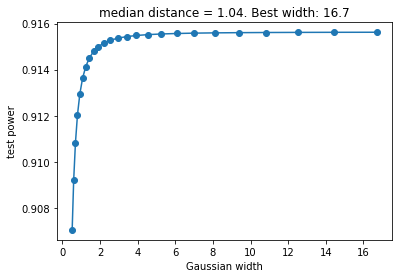

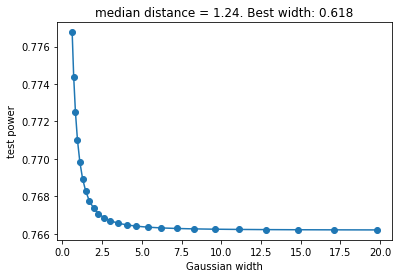

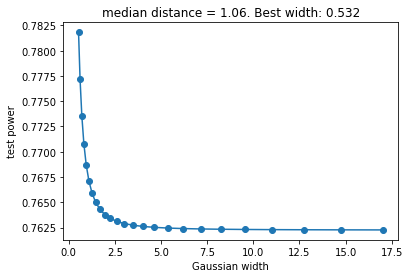

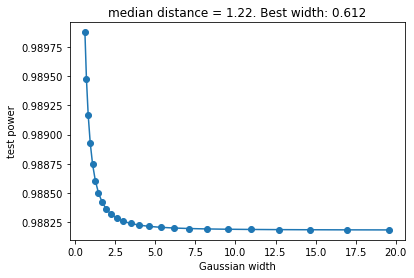

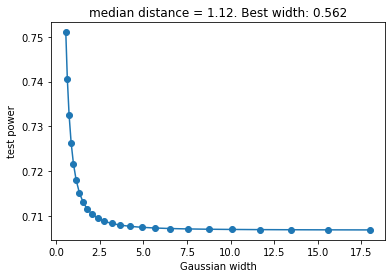

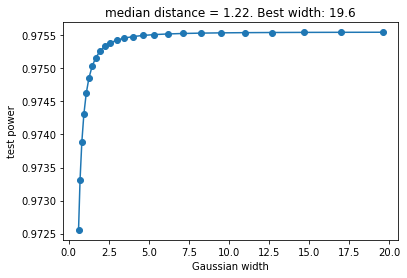

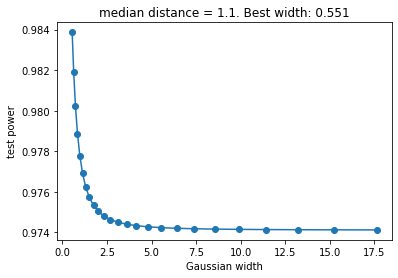

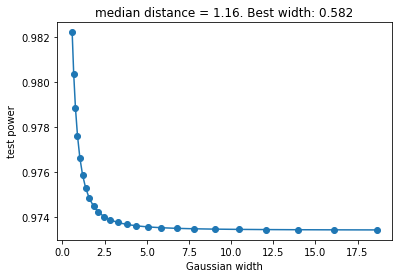

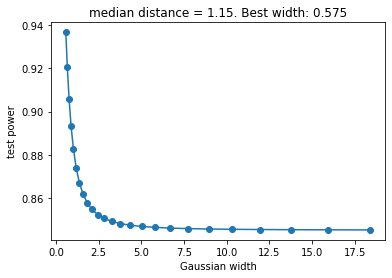

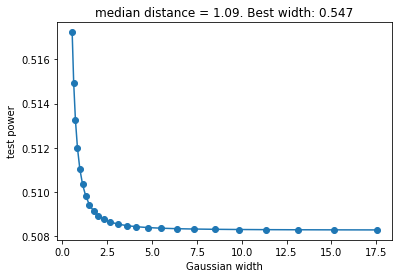

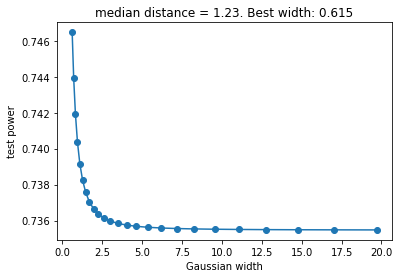

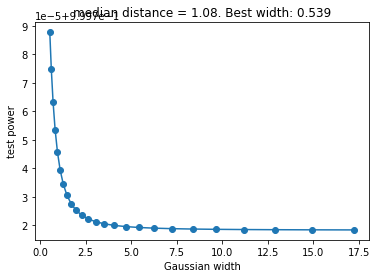

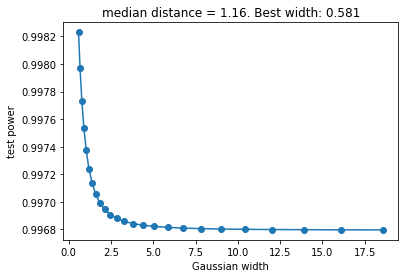

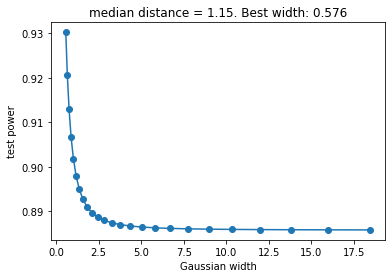

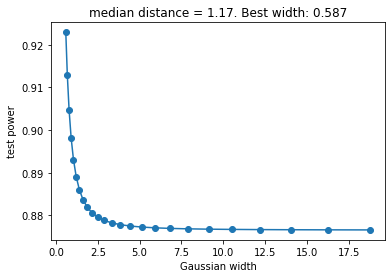

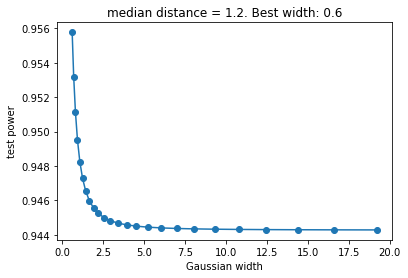

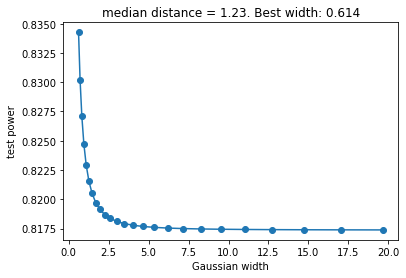

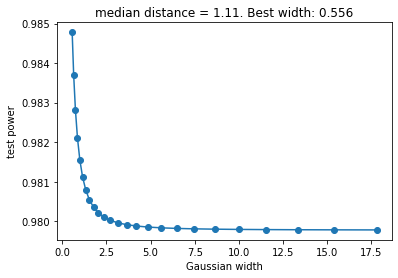

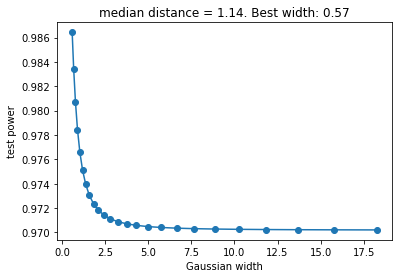

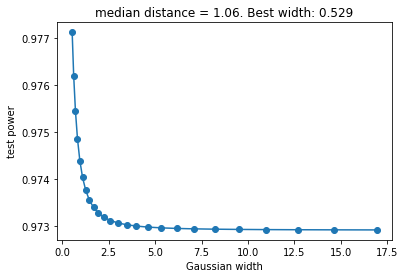

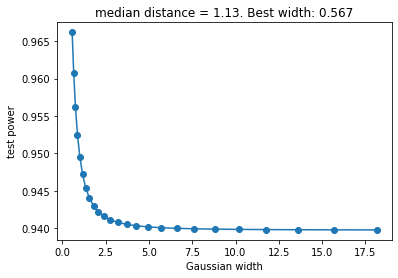

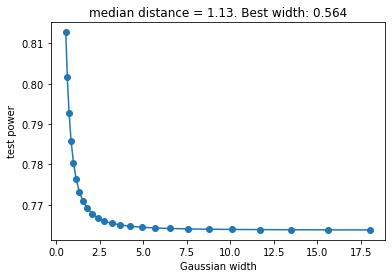

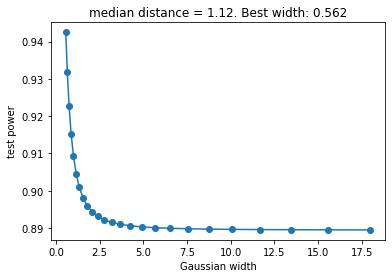

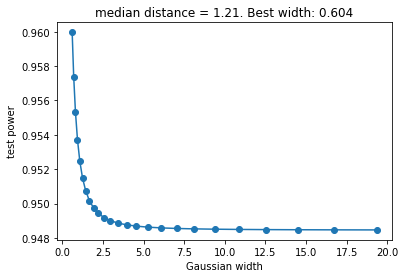

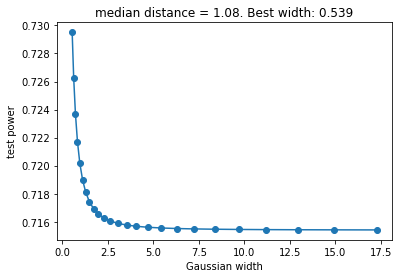

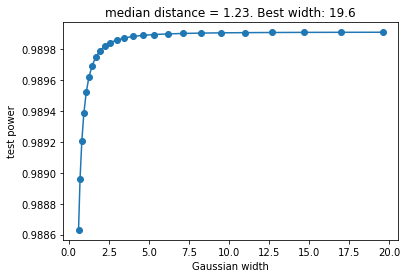

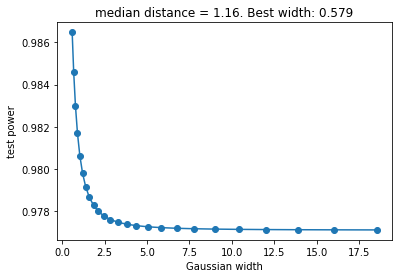

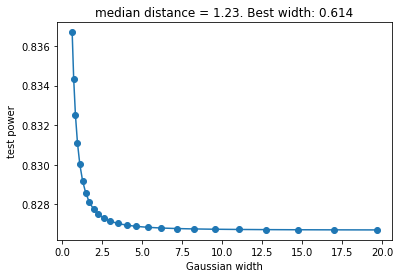

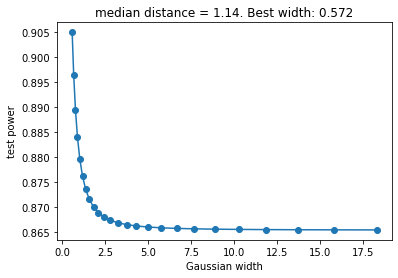

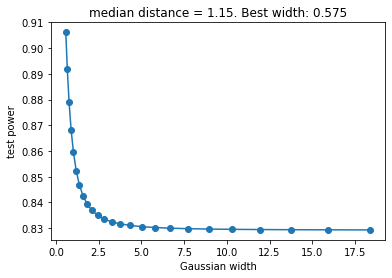

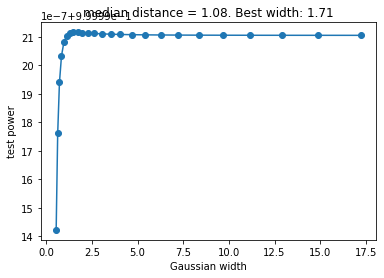

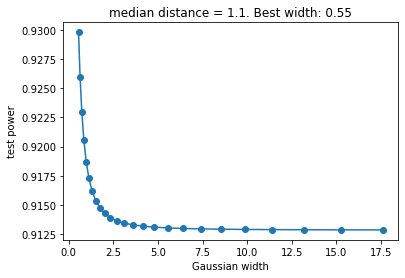

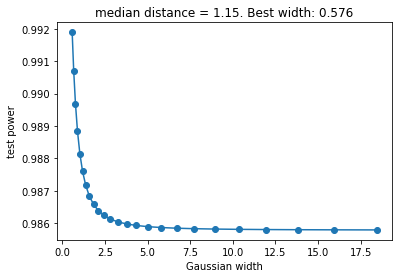

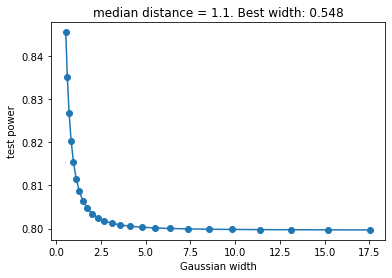

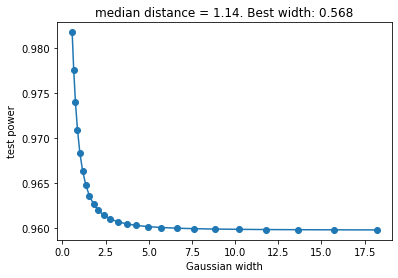

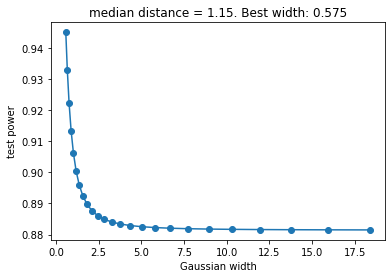

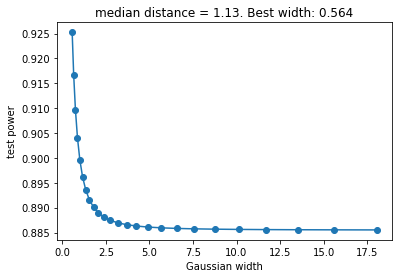

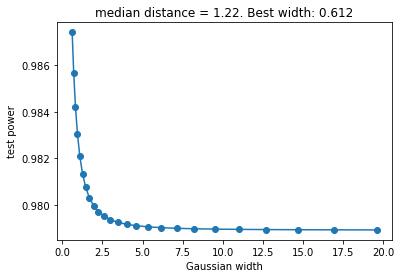

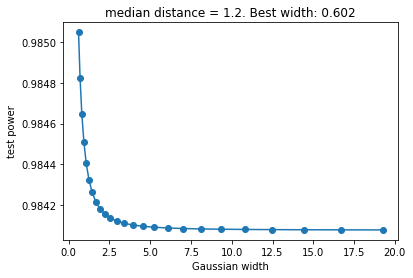

Exception ignored in: <function TransformNode.set_children.<locals>.<lambda> at 0x7fb611986b90>
Traceback (most recent call last):
  File "/home/ak/anaconda3/envs/timeSeries/lib/python3.7/site-packages/matplotlib/transforms.py", line 177, in <lambda>
    ref = weakref.ref(self, lambda ref, sid=id(self),
KeyboardInterrupt


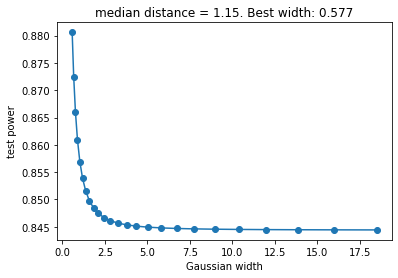

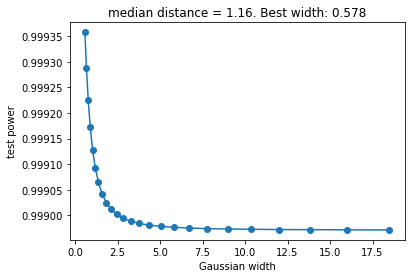

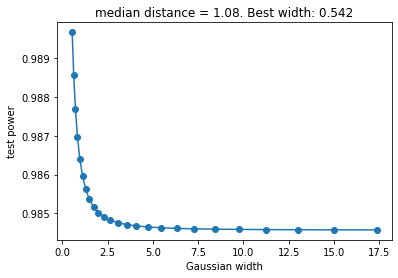

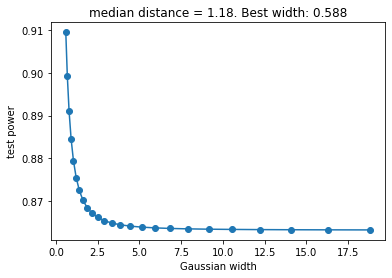

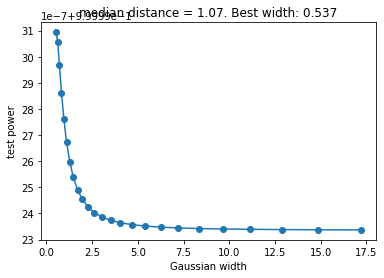

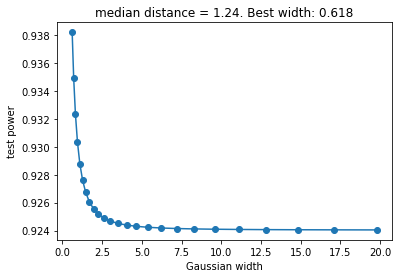

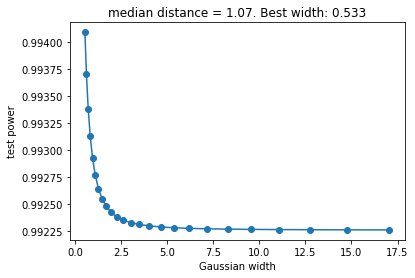

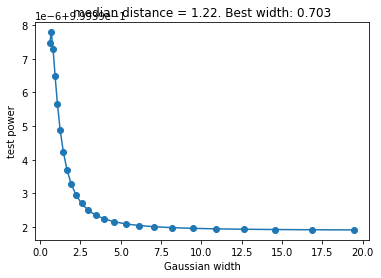

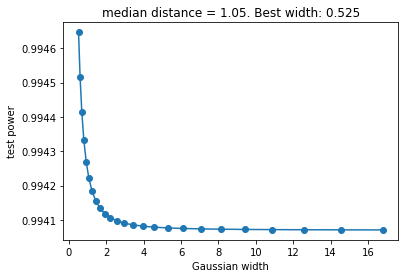

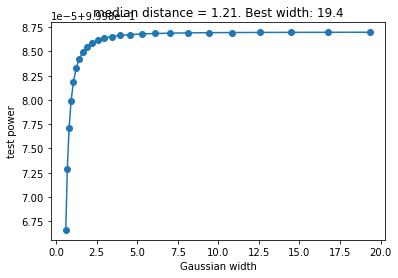

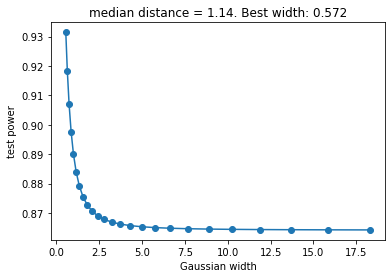

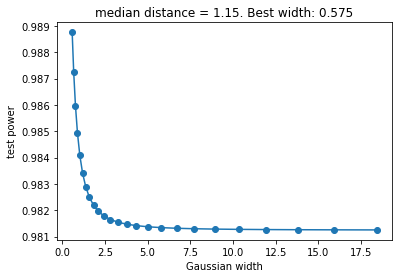

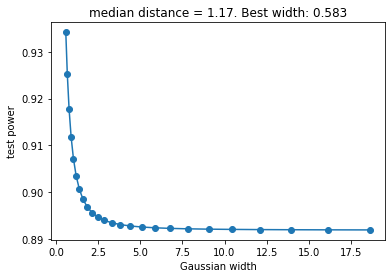

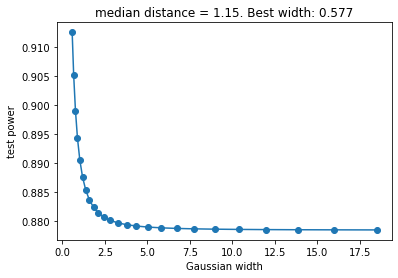

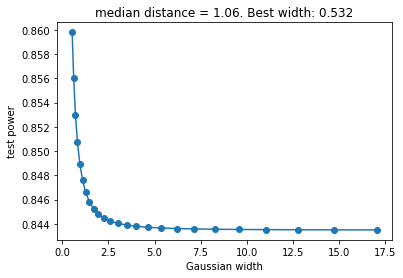

ValueError: Dimension sizes of the two datasets must be the same.

In [10]:
unpickled_df = tau_df
num_columns = unpickled_df.shape[1]
mmd_tester = MMDTester(unpickled_df)

column_combinations = list(generate_column_pairs(num_columns))

# Initialize an empty dictionary to store the results
results = {}

# Iterate through all column combinations
for start_point, end_point, shift in column_combinations:
    test_results_one, test_results_two = mmd_tester.analyze(start_point, end_point, shift, end_point - start_point)
    
    col1, col2 = unpickled_df.columns[start_point], unpickled_df.columns[end_point + shift]
    results[f"{col1}_vs_{col2}"] = (test_results_one, test_results_two)

print(results)

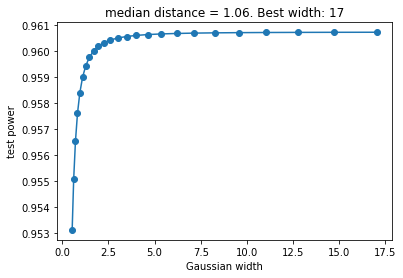

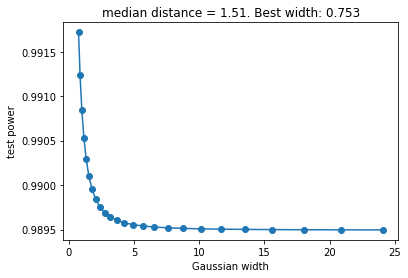

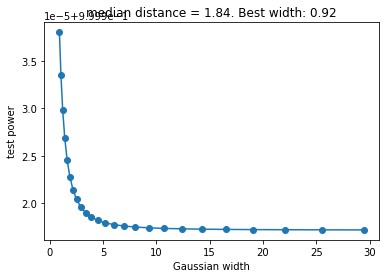

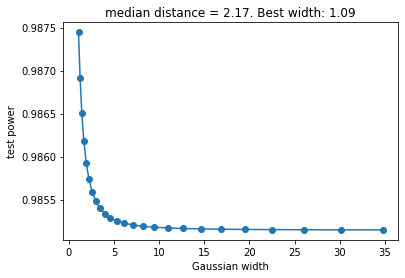

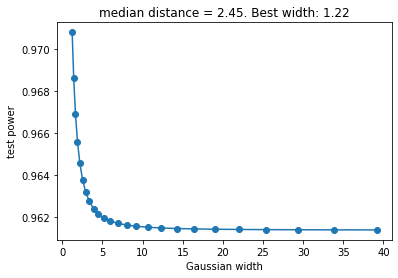

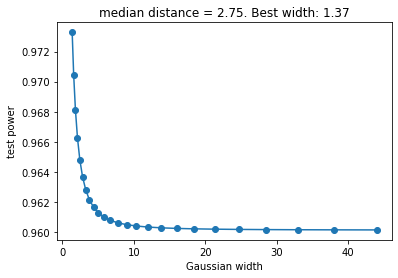

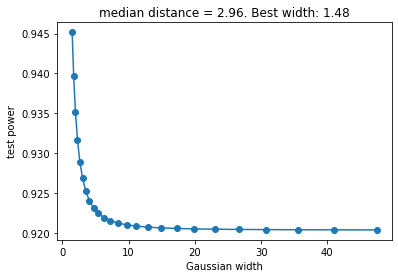

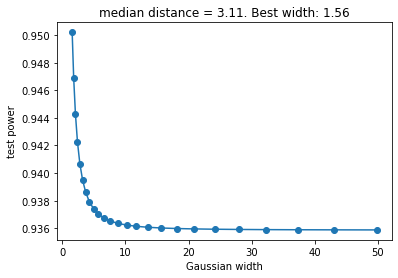

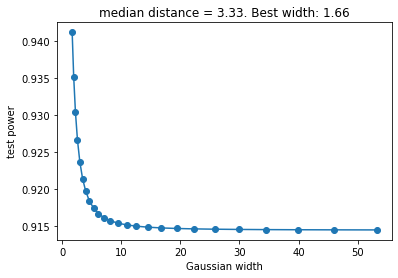

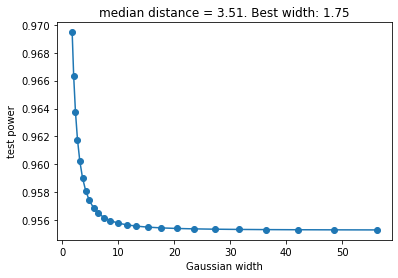

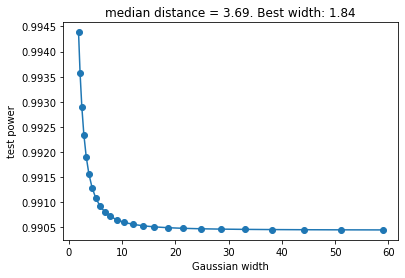

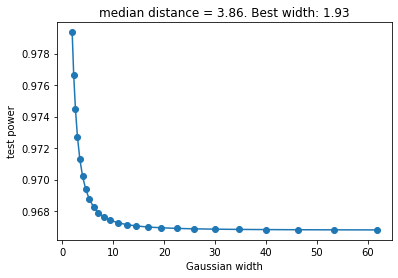

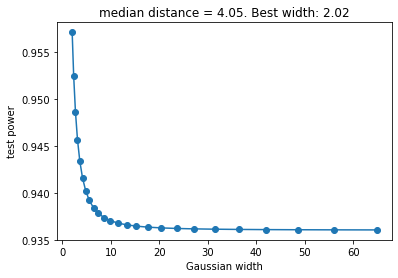

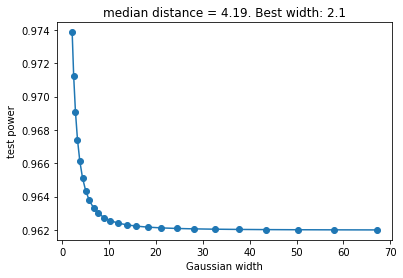

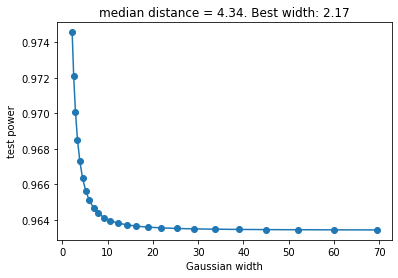

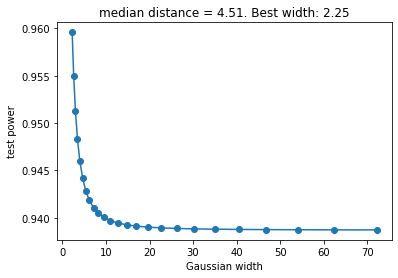

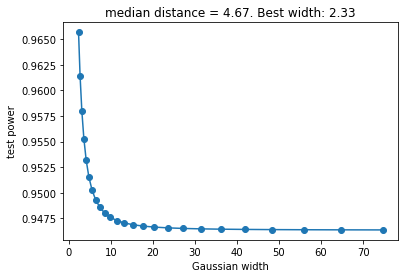

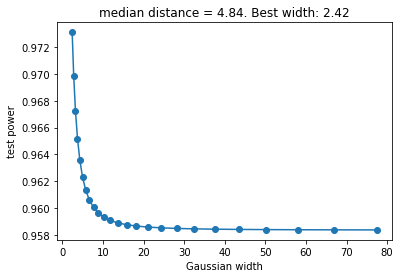

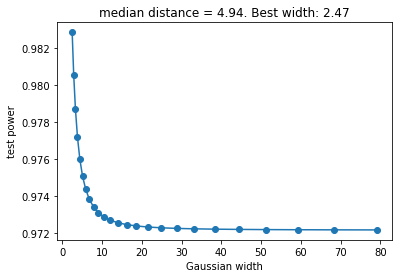

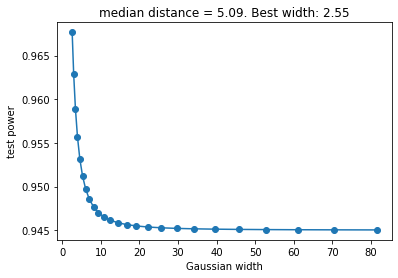

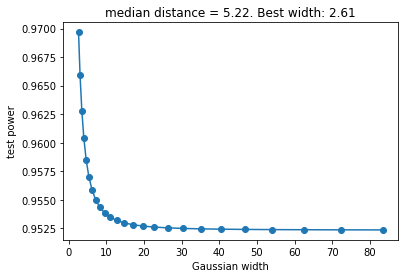

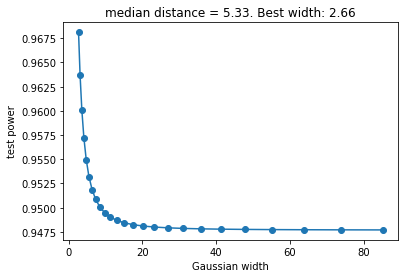

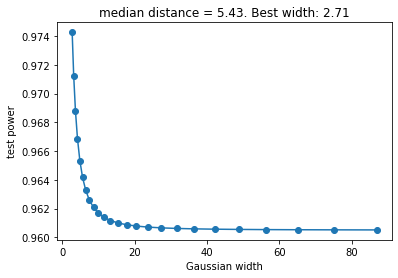

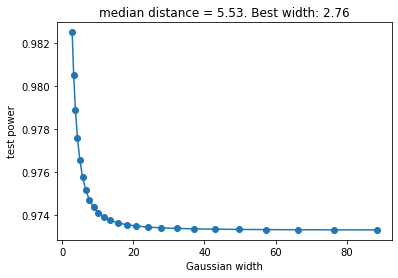

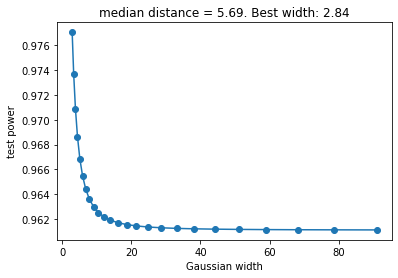

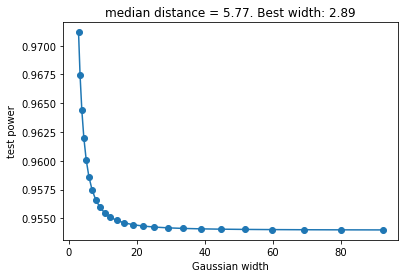

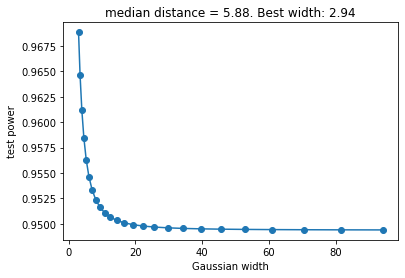

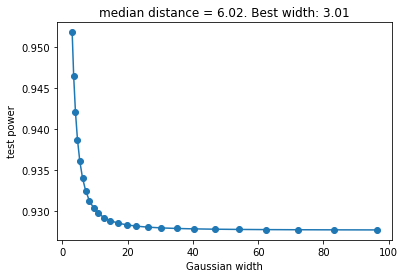

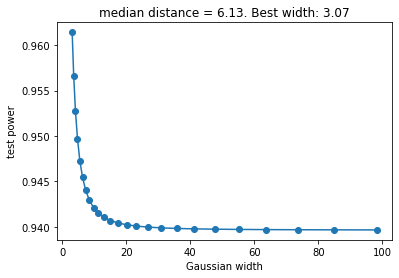

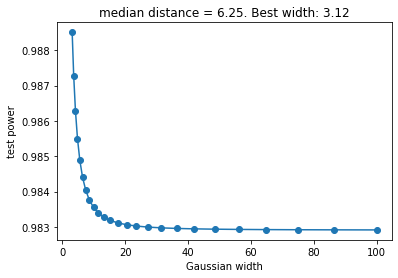

ValueError: Dimension sizes of the two datasets must be the same.

In [11]:
# Generate all possible combinations of start_point, end_point, and shift
column_combinations = [(start_point, end_point, shift) 
                       for start_point in range(0, num_columns - 1) 
                       for end_point in range(1, num_columns) 
                       for shift in range(1, num_columns - start_point) 
                       if end_point - start_point == shift]

# Iterate through all column combinations
for start_point, end_point, shift in column_combinations:
    test_results_one, test_results_two = mmd_tester.analyze(start_point, end_point, shift, end_point - start_point)

    col1, col2 = unpickled_df.columns[start_point], unpickled_df.columns[end_point + shift]
    result_key = f"{col1}_vs_{col2}"
    test_results_one_dict[result_key] = test_results_one
    test_results_two_dict[result_key] = test_results_two

In [ ]:
# Iterate through all column combinations
for start_point, end_point, shift in column_combinations:
    try:
        test_results_one, test_results_two = mmd_tester.analyze(start_point, end_point, shift, end_point - start_point)

        col1, col2 = unpickled_df.columns[start_point], unpickled_df.columns[end_point + shift]
        result_key = (col1, col2, shift, end_point - start_point)
        results[result_key] = (test_results_one, test_results_two)

    except ValueError as e:
        print(f"Skipping combination {start_point}, {end_point}, {shift} due to error: {e}")
        continue

# Print the results
for key, value in results.items():
    print(f"{key}: {value}")

In [ ]:
test_results_one

In [12]:
from multiprocessing import Pool, cpu_count
unpickled_df = alpha_df
num_columns = unpickled_df.shape[1]
mmd_tester = MMDTester(unpickled_df)

def analyze_column(start_point, end_point, shift, window):
    
    try:
        test_results_one, test_results_two = mmd_tester.analyze(start_point, end_point, shift, window)
        col1, col2 = unpickled_df.columns[start_point], unpickled_df.columns[end_point + shift]
        result_key = f"{col1} vs {col2}, window={window}, shift={shift}"
        return {result_key: (test_results_one, test_results_two)}
    except ValueError:
        pass

# Generate all possible combinations of column pairs, window sizes, and shifts
column_pairs = list(combinations(unpickled_df.columns, 2))
windows = range(5, 201, 5)
shifts = range(1, 11)

# Create a list of arguments for the analyze_column function
args_list = []
for start_point, end_point in combinations(range(len(unpickled_df.columns)), 2):
    for window in windows:
        for shift in shifts:
            args_list.append((start_point, end_point, shift, window))

# Use multiprocessing to analyze the data in parallel
with Pool(processes=cpu_count()) as pool:
    results = pool.starmap(analyze_column, args_list)

# Combine the results into a single dictionary
result_dict = {}
for r in results:
    if r:
        result_dict.update(r)

# Convert the dictionary to a DataFrame
result_df = pd.DataFrame.from_dict(result_dict, orient='index', columns=['Test Results 1', 'Test Results 2'])

# # Save the results to a CSV file
# result_df.to_csv('test_results.csv')


In [14]:
# Convert the results dictionary to a DataFrame
result_df = pd.DataFrame.from_dict(result_dict)


# Split the column names into multiple levels
result_df.columns = result_df.columns.str.split(', ', expand=True)
result_df

0 vs 2  \
                                            window=5   
                                             shift=1   
0  {'widths': [0.14993147325597408, 0.17322373197...   
1  {'test_result': {'alpha': 0.01, 'pvalue': 0.00...   

                                                      \
                                           window=10   
                                             shift=1   
0  {'widths': [0.14993147325597408, 0.17322373197...   
1  {'test_result': {'alpha': 0.01, 'pvalue': 0.00...   

                                                      \
                                           window=15   
                                             shift=1   
0  {'widths': [0.14993147325597408, 0.17322373197...   
1  {'test_result': {'alpha': 0.01, 'pvalue': 2.61...   

                                                      \
                                           window=20   
                                             shift=1   
0  {'widths': [0.14993147325597408, 0.17322373197...   
1  {'test_result': {'alpha': 0.01, 'pvalue': 0.00...   

                                                      \
                                           window=25   
                                             shift=1   
0  {'widths': [0.14993147325597408, 0.17322373197...   
1  {'test_result': {'alpha': 0.01, 'pvalue': 1.45...   

                                                      \
                                           window=30   
                                             shift=1   
0  {'widths': [0.14993147325597408, 0.17322373197...   
1  {'test_result': {'alpha': 0.01, 'pvalue': 0.00...   

                                                      \
                                           window=35   
                                             shift=1   
0  {'widths': [0.14993147325597408, 0.17322373197...   
1  {'test_result': {'alpha': 0.01, 'pvalue': 3.60...   

                                                      \
                                           window=40   
                                             shift=1   
0  {'widths': [0.14993147325597408, 0.17322373197...   
1  {'test_result': {'alpha': 0.01, 'pvalue': 1.76...   

                                                      \
                                           window=45   
                                             shift=1   
0  {'widths': [0.14993147325597408, 0.17322373197...   
1  {'test_result': {'alpha': 0.01, 'pvalue': 6.19...   

                                                      ...  \
                                           window=50  ...   
                                             shift=1  ...   
0  {'widths': [0.14993147325597408, 0.17322373197...  ...   
1  {'test_result': {'alpha': 0.01, 'pvalue': 1.62...  ...   

                                            83 vs 85  \
                                            window=5   
                                             shift=1   
0  {'widths': [0.16876635793297914, 0.19498466677...   
1  {'test_result': {'alpha': 0.01, 'pvalue': 1.14...   

                                            83 vs 90  \
                                            window=5   
                                             shift=6   
0  {'widths': [0.1494547489134595, 0.172672947217...   
1  {'test_result': {'alpha': 0.01, 'pvalue': 1.42...   

                                            83 vs 87  \
                                            window=5   
                                             shift=2   
0  {'widths': [0.22496994010047067, 0.25991962701...   
1  {'test_result': {'alpha': 0.01, 'pvalue': 1.30...   

                                            83 vs 89  \
                                            window=5   
                                             shift=4   
0  {'widths': [0.2077001074250231, 0.239966879254...   
1  {'test_result': {'alpha': 0.01, 'pvalue': 2.74...   

                                            84 vs 86  \
                               

In [15]:
# Set the column names as a multi-index
result_df.columns = pd.MultiIndex.from_tuples(result_df.columns, names=['column_pair', 'window', 'shift'])

# Transpose the DataFrame to make the indices into columns
result_df = result_df.stack(level=['window', 'shift']).reset_index()

# Rename the index column
result_df = result_df.rename(columns={'level_0': 'Result'})

# Print the resulting DataFrame
print(result_df)

column_pair  Result     window     shift  \
0                 0  window=10   shift=1   
1                 0  window=10  shift=10   
2                 0  window=10   shift=2   
3                 0  window=10   shift=3   
4                 0  window=10   shift=4   
..              ...        ...       ...   
329               1  window=85   shift=3   
330               1  window=85   shift=4   
331               1  window=85   shift=5   
332               1  window=85   shift=6   
333               1  window=90   shift=1   

column_pair                                            0 vs 10  \
0                                                          NaN   
1                                                          NaN   
2                                                          NaN   
3                                                          NaN   
4                                                          NaN   
..                                                         ...   
329      

In [19]:
from multiprocessing import Pool, cpu_count
unpickled_dataframe = alpha_df
num_columns = unpickled_dataframe.shape[1]



def analyze_column(mmd_tester, start_point, end_point, shift, window):
    try:
        test_results_one, test_results_two = mmd_tester.analyze(start_point, end_point, shift, window)
        col1, col2 = unpickled_df.columns[start_point], unpickled_df.columns[end_point + shift]
        result_key = f"{col1} vs {col2}, window={window}, shift={shift}"
        return {result_key: (test_results_one, test_results_two)}
    except ValueError:
        pass

# Define MMDTester object
mmd_tester = MMDTester(unpickled_dataframe)

# Generate all possible combinations of column pairs, window sizes, and shifts
column_pairs = list(combinations(unpickled_dataframe.columns, 2))
windows = range(5, 201, 5)
shifts = range(1, 11)

# Create a list of arguments for the analyze_column function
args_list = []
for start_point, end_point in combinations(range(len(unpickled_dataframe.columns)), 2):
    for window in windows:
        for shift in shifts:
            args_list.append((mmd_tester, start_point, end_point, shift, window))

# Use multiprocessing to analyze the data in parallel
with Pool(processes=cpu_count()) as pool:
    results = pool.starmap(analyze_column, args_list)

# Combine the results into a single dictionary
result_dict = {}
for r in results:
    if r:
        result_dict.update(r)

# Convert the dictionary to a DataFrame
result_df = pd.DataFrame.from_dict(result_dict, orient='index', columns=['Test Results 1', 'Test Results 2'])

# Save the results to a CSV file
result_df.to_csv('test_results.csv')


In [21]:
result_df

,Test Results 1,Test Results 2
"0 vs 2, window=5, shift=1","{'widths': [0.14993147325597408, 0.17322373197...","{'test_result': {'alpha': 0.01, 'pvalue': 0.00..."
"0 vs 2, window=10, shift=1","{'widths': [0.14993147325597408, 0.17322373197...","{'test_result': {'alpha': 0.01, 'pvalue': 0.00..."
"0 vs 2, window=15, shift=1","{'widths': [0.14993147325597408, 0.17322373197...","{'test_result': {'alpha': 0.01, 'pvalue': 2.61..."
"0 vs 2, window=20, shift=1","{'widths': [0.14993147325597408, 0.17322373197...","{'test_result': {'alpha': 0.01, 'pvalue': 0.00..."
"0 vs 2, window=25, shift=1","{'widths': [0.14993147325597408, 0.17322373197...","{'test_result': {'alpha': 0.01, 'pvalue': 1.45..."
...,...,...
"84 vs 90, window=5, shift=5","{'widths': [0.13671142587037743, 0.15794991457...","{'test_result': {'alpha': 0.01, 'pvalue': 6.49..."
"84 vs 88, window=5, shift=2","{'widths': [0.22263820704328874, 0.25722565293...","{'test_result': {'alpha': 0.01, 'pvalue': 3.36..."
"84 vs 89, window=5, shift=3","{'widths': [0.20976422585033191, 0.24235166404...","{'test_result': {'alpha': 0.01, 'pvalue': nan,..."
"85 vs 87, window=5, shift=1","{'widths': [0.16620514303798223, 0.19202556024...","{'test_result': {'alpha': 0.01, 'pvalue': 2.96..."


In [22]:
from multiprocessing import Pool, cpu_count

def analyze_column(start_point, end_point, shift, window, mmd_tester):
    try:
        test_results_one, test_results_two = mmd_tester.analyze(start_point, end_point, shift, window)
        col1, col2 = unpickled_df.columns[start_point], unpickled_df.columns[end_point + shift]
        result_key = f"{col1} vs {col2}, window={window}, shift={shift}"
        return {result_key: {'Test Results 1': test_results_one, 'Test Results 2': test_results_two}}
    except ValueError:
        pass

# Generate all possible combinations of column pairs, window sizes, and shifts
column_pairs = list(combinations(unpickled_dataframe.columns, 2))
windows = range(5, 201, 5)
shifts = range(1, 11)

# Create a list of arguments for the analyze_column function
args_list = []
for start_point, end_point in combinations(range(len(unpickled_dataframe.columns)), 2):
    for window in windows:
        for shift in shifts:
            args_list.append((start_point, end_point, shift, window))

# Create an instance of the MMDTester class outside the analyze_column function
mmd_tester = MMDTester(unpickled_dataframe)

# Use multiprocessing to analyze the data in parallel
with Pool(processes=cpu_count()) as pool:
    results = pool.starmap(analyze_column, [(arg[0], arg[1], arg[2], arg[3], mmd_tester) for arg in args_list])

# Combine the results into a single dictionary
result_dict_nested = {}
for r in results:
    if r:
        result_dict_nested.update(r)

# Save the results to a CSV file
import csv
with open(os.path.join(outputDir, 'test_results.csv'), 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['Column Pair', 'Window', 'Shift', 'Test Results 1', 'Test Results 2'])
    for key, value in result_dict_nested.items():
        col_pair, window, shift = key.split(', ')
        writer.writerow([col_pair, window, shift, value['Test Results 1'], value['Test Results 2']])

In [26]:
result_dict_nested['0 vs 6, window=30, shift=3'].keys()

dict_keys(['Test Results 1', 'Test Results 2'])

In [30]:
list(result_dict_nested['0 vs 6, window=30, shift=3']['Test Results 1'].keys())

['widths',
 'med',
 'besti',
 'powers',
 'med_on_test_data',
 'test_result',
 'test_variance',
 'two_moments',
 'compute_unbiased_linear_estimator']

In [31]:
result_dict = result_dict_nested
df = pd.DataFrame(columns=result_dict.keys())

In [44]:
pd.DataFrame.from_dict(result_dict_nested['0 vs 2, window=5, shift=1'])

,Test Results 1,Test Results 2
widths,"[0.14993147325597408, 0.17322373197232271, 0.2...",NaN
med,0.299863,NaN
besti,0,NaN
powers,"[0.9999789775103449, 0.9999517248272151, 0.999...",NaN
med_on_test_data,0.282391,0.284219
test_result,"{'alpha': 0.01, 'pvalue': 0.000738759125454372...","{'alpha': 0.01, 'pvalue': 0.000218194651806118..."
test_variance,-0.016003,-0.0212948
two_moments,"(0.13510072654143795, 0.06230689590163673)","(0.14518739714717263, 0.05879257913496785)"
compute_unbiased_linear_estimator,0.135101,0.145187


In [34]:
# Iterate over the results in the dictionary
for key, value in result_dict.items():
    # Extract the two test results from the tuple
    test_results_one, test_results_two = value
    # Loop over the keys in each test result and add them to the DataFrame
    for test_key in ['Test Results 1', 'Test Results 2']:
        for result_key, result_value in eval(test_key.lower()).items():
            if isinstance(result_value, list):
                # For keys with list values, calculate the median and add it to the DataFrame
                df.loc[(test_key, result_key), key] = np.median(result_value)
            else:
                # For other keys, add the value directly to the DataFrame
                df.loc[(test_key, result_key), key] = result_value

# # Print the resulting DataFrame
# print(df)

SyntaxError: invalid syntax (<string>, line 1)

In [37]:
# create an empty DataFrame with the appropriate multi-level column index
column_index = pd.MultiIndex.from_product([['Test Results 1', 'Test Results 2'],
                                            ['widths', 'med', 'besti', 'med_on_test_data', 
                                             'test_variance', 'two_moments', 
                                             'compute_unbiased_linear_estimator', 
                                             'test_result.alpha', 'test_result.pvalue', 
                                             'test_result.test_stat', 'test_result.h0_rejected']])
results_df = pd.DataFrame(columns=result_dict.keys(), index=column_index)

# populate the DataFrame with the results
for test_key in results_df.columns:
    for result_key, result_value in result_dict[test_key]:
        if isinstance(result_value, dict):
            for subkey, subvalue in result_value.items():
                if isinstance(subvalue, np.ndarray):
                    subvalue = np.median(subvalue)
                results_df.loc[(test_key.split(', ')[0], subkey), test_key] = subvalue
        elif isinstance(result_value, np.ndarray):
            results_df.loc[('Test Results 2', 'powers'), test_key] = np.median(result_value)
        else:
            results_df.loc[('Test Results 1', result_key), test_key] = result_value

# display the DataFrame
print(results_df)

ValueError: too many values to unpack (expected 2)

In [39]:
# create an empty DataFrame with the appropriate multi-level column index
column_index = pd.MultiIndex.from_product([['Test Results 1', 'Test Results 2'],
                                            ['widths', 'med', 'besti', 'med_on_test_data',                                             'test_variance', 'two_moments',                                             'compute_unbiased_linear_estimator',                                             'test_result.alpha', 'test_result.pvalue',                                             'test_result.test_stat', 'test_result.h0_rejected']])
results_df = pd.DataFrame(columns=result_dict.keys(), index=column_index)

# populate the DataFrame with the results
for test_key in results_df.columns:
    result_value = result_dict[test_key]
    for result_key, result_data in result_value.items():
        if isinstance(result_data, dict):
            for subkey, subvalue in result_data.items():
                if isinstance(subvalue, np.ndarray):
                    subvalue = np.median(subvalue)
                results_df.loc[(test_key.split(', ')[0], subkey), test_key] = subvalue
        elif isinstance(result_data, np.ndarray):
            results_df.loc[('Test Results 2', 'powers'), test_key] = np.median(result_data)
        else:
            results_df.loc[('Test Results 1', result_key), test_key] = result_data

# display the DataFrame
print(results_df)


ValueError: cannot set using a multi-index selection indexer with a different length than the value

In [41]:
for test_key in results_df.columns:
    result_data = result_dict[test_key]
    for result_key in result_data:
        if isinstance(result_data[result_key], dict):
            for subkey, subvalue in result_data[result_key].items():
                if isinstance(subvalue, np.ndarray):
                    subvalue = np.median(subvalue)
                results_df.loc[(test_key.split(', ')[0], subkey), test_key] = subvalue
        elif isinstance(result_data[result_key], np.ndarray):
            results_df.loc[('Test Results 2', 'powers'), test_key] = np.median(result_data[result_key])
        else:
            results_df.loc[('Test Results 1', result_key), test_key] = result_data[result_key]


ValueError: cannot set using a multi-index selection indexer with a different length than the value